## Introduction 

Here we are trying to adjust parameters of a paraphrase model to generate adversarial examples. 
### Policy gradients 
The key parameter update equation is $\theta_{t+1} = \theta_t + \alpha \nabla_\theta J(\theta)$, where $\alpha$ is a step size parameter, the parameter vector $\theta$ is for a model (here a paraphrase model), and $J$ is a loss function. The time step $t$ depends on the problem specification and we will get to it later. 

Now in my review I have defined the loss function $J(\theta) = E_\pi[r(\tau)]$. Here: 
* $\pi$ is the policy, a probability distribution for the next action in a given state; essentially $p(a_t|s_t)$
* $\tau$ is a trajectory, a specific sequence $s_0, a_0, r_1, s_1, a_1, \ldots$ of the agent in the game. This starts at time $t=0$ and finishes at time $t=T$. 
* $r(\tau)$ is the sum of rewards for a trajectory $\tau$, or in other words, the total reward for the trajectory. 

For this loss function higher values are better (which might make it a reward function) and so we might have to invert it at some point. 

To update parameters we must find the gradient $\nabla_\theta J(\theta)$, which measures how $J(\theta)$ changes when we adjust the parameters of the paraphrase model. The gradient is simplified through some maths to get the policy gradient theorem $$ \nabla_\theta J(\theta) =  \nabla_\theta E_\pi [r(\tau)]  = E_\pi \left[r(\tau) \sum_{t=1}^T \nabla_\theta \log \pi (a_t|s_t)  \right] $$ 

To calculate this you need to calculate the expectation term, which in turn means evaluating every possible trajectory $\tau$ and its expected return. Generally this is not possible and instead we turn to estimators.  

One of these is REINFORCE. It gives us  $$ \nabla_\theta J(\theta) \approx \sum_{s=1}^S \sum_{t=1}^T G_t \nabla \log \pi(a_t|s_t)$$ where 
* $G_t$ is the discounted return and is given by $G_t = r_t + \beta r_{t-1} + \beta^2 r_{t-2} + \dots$. It's a rough estimate of $r(\tau)$. Rewards obtained later in the episode are weighted much higher than rewards obtained earlier. I guess it assumes that the parameters update every timestep. 
* $S$ is some number of samples.

The implementation of REINFORCE and similar estimators depends on how we formulate the problem. Below we present some possible formulations

### Interpretation One: Document-level  
This is the first implementation we will try. 

Here we generate a list of paraphrases at each time point. The idea is that there is one paraphrase amongst them that is a good adversarial example. We try to tune the model to produce the best one. 

This interpretation sees forming the complete paraphrase as one time step. So it isn't token-level but document-level. 

* Starting state: $s0 = x$, the original example  
* Actions: each action is "choosing" a paraphrase (or of choosing $n$ paraphrases). The set of all possible paraphrases and their probabilities is the policy. So $\pi(a|s) = p(x'| x;\theta)$ where $x'$ is the paraphrase (or list of paraphrases). 
    * To approximate this probability, what we can do is generate a large list of paraphrases, and for each, the probabilities of generating each token in turn for that paraphrase. This gives a rough "probability" of how likely that sequence was. This number is kind of like a weight for how good that paraphrase is, according to the model.  We can then turn the weights into probabilities to get a "probability" of the paraphrase. This is dependent on the number of paraphrases generated, so generating a large list is likely to be better for this task. 
* Reward: The paraphrase moves through the reward function $R(x, x')$) to get the reward $r$. 
* Time steps: We only have one time step in the game ($T=1$ and $G_t=r$)  


There are a few variations to this scenario that we can do. For each of these we will formulate the policy and the reward function $R$. Below, $x'$ means paraphrase, $f(x)_y$ means the model confidence of x for the class of the true label $y$, $SS(a,b)$ is the result of a semantic similarity model run over $a$ and $b$, and $\lambda$ is a hyperparameter.  


#### One-paraphrase 
Here we only generate one paraphrase. This scenario also has a few options. First we generate a list of paraphrases with the probabilities of selecting one. Then we either sample probabilistically from the list or pick the most probable option. 

In this case the policy $p(x'|x,\theta)$ is the chance of obtaining a specific paraphrase. For the sampling option this is equal to its sample probability. For the top option this is just the probability of selecting that option. 

The reward function might look like $R(x,x') = f(x)_y - f(x')_y + \lambda SS(x, x')$. We could also make the $SS$ factor a step-function above some threshold. 

The REINFORCE equation $$ \nabla_\theta J(\theta) \approx \sum_{s=1}^S \sum_{t=1}^T G_t \nabla \log \pi(a_t|s_t)$$ becomes $$ \nabla_\theta J(\theta) \approx \sum_{s=1}^S  R(x,x'_s) \nabla \log p(x'_s|x,\theta)$$ We repeat the process $S$ times where $S$ is ideally as large as possible. We can start with something simple (e.g. $S=10$ or $S=100$) and go from there.  

The gradient term $\nabla \log p(x'_s|x,\theta)$ can hopefully be found with autodiff. 

#### Set of paraphrases
In this scenario the paraphrase model is evaluated on performance over a set of paraphrases, which we call $X'$ here. The policy becomes $p(X'|x, \theta)$, the probability of obtaining that list. We can get this probability by multipling together the "probability" of each individual paraphrase, multiplying also by nCr (for r paraphrases out of n total) to account for the lack of order in the list. 

We can make a number of sub-scenarios here. 

For the **top-paraphrase in set** condition the paraphrase generator is only measured on the best reward for a paraphrase in its set. The idea is the generator will learn to produce a diverse set of examples, any of which could plausibly be a good adversarial example. Here we only look at best performing paraphrase $x'_m$, which we can find by $x'_m = \max_i [f(x)_y - f(x'_i)_y]$, then return $R(x,x'_m) = [f(x)_y - f(x'_m)_y] + \lambda SS(x,x'_m)$ 

For the **average-paraphrase in set** condition the paraphrase generator is measured on the average reward of the paraphrases in its set. This encourages the generator to consider performance of all examples more-or-less equally. The reward function could be something like $\frac{1}{k} \sum_{i=1}^k \left[ f(x)_y - f(x'_i)_y + \lambda SS(x, x'_i) \right]$ 

A combination of these scenarios is the **top-k/top-p\% paraphrases in set**. Here we only use the top-$k$ paraphrases, or more generally, the top $p$ percentage of paraphrases. 


### Interpretation 2: Token-level
This interpretation is at token-level; it sees choosing the next word as the next time step. 

* Starting state: $s0 = x$, the initial state. But you also have a "blank slate" for the paraphrase. So maybe it's a tuple (x, pp) where pp is a paraphrase with no words. Here x is used as the reference for the paraphrase generator.  
* Actions: Choose the next word of p. I guess this starts with the \<START\> token (or something similar). Then you have the policy $\pi(a|s)$ which is the same as $p(w_{next}|pp, x; \theta)$ where $\theta$ is the paraphrase model parameters, $pp$ is the so-far constructed sentence, and $w_{next}$ is the next token (I say token because I don't know if this model is on the subword or word basis). 
* Time steps: every token is generated one-by-one and each of these is allocated a time step. This means probably that you also update the parameters after each token generated too. 
* Reward. The reward is allocated every token. There are many reward functions (see papers on token-level loss functions). Some also incorporate document-level rewards too. 
* Next state. $s_1$ is again the tuple $(x, pp)$ but now $pp$ has the first word in it. 

On *teacher forcing*. This is when you have a ground-truth paraphrase and you can use it when generating tokens. This is useful because if the model makes a mistake it doesn't continue down that track but is adjusted back. This stops big divergences (but also might limit the diversity of generated paraphrases). This is used when training a paraphrase model. You have a set of reference paraphrases that are human provided. Here though we only have the original sentence and no references. We could generate adversarial examples and use that to do teacher forcing. Generating them using textattack recipes might work. This is only really used on the token-level rewards. 

### Updating the paraphrase model parameters. 

There is a choice here. We can either directly update the parameters of the paraphrase model. Or we can fix the parameters and add a new dense layer to the end of the model. We could then train this dense layer to convert paraphrases to adversarial paraphrases. 

Before trying this out, I am worried that we will destroy the capabilities of the paraphrase generator a bit. We might get semantically invalid or ungrammatical or gibberish text. If so we could try and mitigate it a bit by shaping our reward function to maintain grammatical components. 

### Experiment order

Plan is to try the following order: 

1. One-paraphrase (most probable option). I'll start with this one because it is probably the most simple case. Within this category: 
    1a. tune existing parameters only (see if the text is recognisable) 
    1b. add dense layer onto end and try again 
2. One-paraphrase (sampled). This seems like a logical extension on the first one. 
3. Paraphrase-set options. (Decide after finishing 1, 2) 
4. Token-level tuning. (Decide after 1,2,3)


### Layer Freezing

I am uncertain on if to do this or not. 

* This [paper](https://arxiv.org/abs/1911.03090) indicates that you can get pretty good results by freezing all layers except the last few 
* Conversely I saw in the transformers documentation that transformers train better if you don't do layer freezing 


## Setup, load models + datasets 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Imports and environment variables 
import os
os.environ["TOKENIZERS_PARALLELISM"]  = "true"  # set to false if not working

# Core imports 
import torch, numpy as np, pandas as pd, gc,sys, logging, warnings
from torch.utils.data import DataLoader
from datasets import load_dataset, load_metric, load_from_disk
from transformers import (AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, SchedulerType, get_scheduler)
from collections import defaultdict
from types import MethodType
import utils; from utils import *   # local script 
from tqdm.auto import tqdm
import itertools
import copy 
import wandb
from undecorated import undecorated


# Dev imports (not needed for final script)
import seaborn as sns
from IPython.display import Markdown
from pprint import pprint
from IPython.core.debugger import set_trace
from GPUtil import showUtilization
import torchsnooper

In [3]:
#### Parameters, notes and training settings

### These parameters mostly don't do anything but are more notes (for the wanb.init function)
debug_run = "true"   # doesn't do anything
sampling_strategy = "greedy"  # doesn't do anything
# copy-paste this from reward function
reward_strategy = "[-0.5 if r < 0.15 else 0.5+v*r for v,r in zip(vm_scores, rouge_scores)]" # doesn't do anything
pp_name = "tuner007/pegasus_paraphrase"
vm_name = "textattack/distilbert-base-uncased-rotten-tomatoes"
dataset_name = "rotten_tomatoes"
n_layers_frozen = "2"  # counting from the back (doesn't do anything yet)
small_ds = True  # for testing purposes
n_shards = 100  # only has effect if small_ds = True
shard_contiguous = False  # only has effect if small_ds = True

### Paraphrase parameters  
pp_model_params = {
    "num_beams": 1, 
    "num_return_sequences": 1, 
    "num_beam_groups": 1, 
    "diversity_penalty": 0.,   # must be a float
    "temperature": 1.5,
    "length_penalty" : 1,
    "min_length" : 5
}

### Training parameters
seed = 420
batch_size = 64
lr = 1e-4 # Initial learning rate (after the potential warmup period) to use
n_train_epochs = 3
eval_freq = 1  # run eval loop every `eval_freq` epochs
normalise_rewards = False
metrics = ['loss', 'pp_logp', 'reward', 'rouge_score', 'vm_score']
#weight_decay = 0
#lr_scheduler_type = 'none'
#n_warmup_steps = 30 

### W&B parameters
wandb_mode = "online"  # set to "disabled" to turn off wandb 
wandb_log_grads = True  
wandb_log_grads_freq = 1  # no effect if wandb_log_grads is False
wandb_n_examples_plot = 15  # number of individual examples to plot curves for

# Parameter dict
config_d = dict(
    debug_run = debug_run,
    sampling_strategy = sampling_strategy,
    reward_strategy = reward_strategy,
    pp_name = pp_name,
    vm_name = vm_name,
    dataset_name = dataset_name, 
    small_ds = small_ds,
    n_layers_frozen = n_layers_frozen,
    pp_model_params = pp_model_params, 
    seed = seed,
    batch_size = batch_size,
    lr = lr, 
    n_train_epochs = n_train_epochs,
    eval_freq = eval_freq,
    normalise_rewards = normalise_rewards,
    metrics = metrics,
    wandb_params=dict(
        log_grads = wandb_log_grads,
        log_grads_freq = wandb_log_grads_freq, 
        n_examples_plot = wandb_n_examples_plot
    )
)
if small_ds: 
    config_d['n_shards'] = n_shards
    config_d['shard_contiguous'] = shard_contiguous



In [4]:
#### Misc setup
# Paths
path_cache = './cache/'
path_results = "./results/"
path_data = "./data/"

# Seeds
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

# Devices and GPU settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
devicenum = torch.cuda.current_device() if device.type == 'cuda' else -1
n_wkrs = 4 * torch.cuda.device_count()

# Configs
pd.set_option("display.max_colwidth", 400)
run_notes = f"Debug run:{debug_run}\nReward: {reward_strategy}\nDataset: {dataset_name}\
\nSampling strategy: {sampling_strategy}"

# Logging 
logging.basicConfig(format='%(message)s', stream=sys.stdout) # stdout while we are doing stdout to file piping
logger = logging.getLogger("main_logger")
logger.setLevel(logging.INFO)

# Other 
splits = ['train', 'valid', 'test']

### Load models

In [5]:
## Paraphrase (pp) model 
pp_tokenizer = AutoTokenizer.from_pretrained(pp_name)
# takes about 3GB memory space up on the GPU
pp_model = AutoModelForSeq2SeqLM.from_pretrained(pp_name, local_files_only=True).to(device)
# The no_grad version of generate
generate_with_grad = undecorated(pp_model.generate)
pp_model.generate_with_grad = MethodType(generate_with_grad, pp_model)

## Victim Model (VM)
vm_tokenizer = AutoTokenizer.from_pretrained(vm_name)
vm_model = AutoModelForSequenceClassification.from_pretrained(vm_name, local_files_only=True).to(device)
vm_idx2lbl = vm_model.config.id2label
vm_lbl2idx = vm_model.config.label2id
vm_num_labels = vm_model.num_labels

### Load raw datasets and create dataloaders

In [6]:
def add_idx(x, idx): x['idx'] = idx; return x   # add row numbers

def get_standard_dataloaders(): 
    """function for standard train/valid/test dataloader setup"""
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,  num_workers=n_wkrs)
    dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=True,  num_workers=n_wkrs)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False, num_workers=n_wkrs)
    return dl_train,dl_valid,dl_test

In [7]:
if dataset_name == "rotten_tomatoes": 
    ds_dict = load_dataset("rotten_tomatoes")
    label_cname = 'label'
    for _,ds in ds_dict.items():
        # make sure that all datasets have the same number of labels as what the victim model predicts
        assert ds.features[label_cname].num_classes == vm_num_labels
    ds_dict = ds_dict.map(add_idx, with_indices=True)
    ds_train,ds_valid,ds_test = ds_dict['train'],ds_dict['validation'],ds_dict['test']
    dl_train,dl_valid,dl_test = get_standard_dataloaders()
elif dataset_name == "simple": 
    def load_and_prep_ds_dl(path): 
        ds = load_dataset('csv',data_files=path)['train']
        ds = ds.map(add_idx, with_indices=True)
        # no shuffle because just for debugging
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=n_wkrs) 
        return ds, dl 
    ds_train,dl_train = load_and_prep_ds_dl(f"{path_data}simple_dataset_train.csv")
    ds_valid,dl_valid = load_and_prep_ds_dl(f"{path_data}simple_dataset_valid.csv")
    ds_test, dl_test  = load_and_prep_ds_dl(f"{path_data}simple_dataset_test.csv")
elif dataset_name=="snli": 
    next
    ## For snli
    # remove_minus1_labels = lambda x: x[label_cname] != -1
    # ds_train = ds_train.filter(remove_minus1_labels)
    # valid = valid.filter(remove_minus1_labels)
    # test = test.filter(remove_minus1_labels)

Using custom data configuration default
Reusing dataset rotten_tomatoes_movie_review (/data/tproth/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/e06abb624abab47e1a64608fdfe65a913f5a68c66118408032644a3285208fb5)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /data/tproth/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/e06abb624abab47e1a64608fdfe65a913f5a68c66118408032644a3285208fb5/cache-719ddcf99ffe3e94.arrow
Loading cached processed dataset at /data/tproth/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/e06abb624abab47e1a64608fdfe65a913f5a68c66118408032644a3285208fb5/cache-e1940dd71a462589.arrow
Loading cached processed dataset at /data/tproth/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/e06abb624abab47e1a64608fdfe65a913f5a68c66118408032644a3285208fb5/cache-0f3c403a3c70b6d3.arrow


In [8]:
## If we want to use a smaller dataset for testing we set that up here. 
if small_ds: 
    ds_train = ds_train.shard(n_shards, 0 , contiguous=shard_contiguous)  
    ds_valid = ds_valid.shard(n_shards, 0 , contiguous=shard_contiguous)   
    ds_test  = ds_test.shard( n_shards, 0 , contiguous=shard_contiguous)  
    dl_train,dl_valid,dl_test = get_standard_dataloaders()

In [9]:
# for easy referencing later
ds_d = dict()
ds_d['train'],ds_d['valid'],ds_d['test'] = ds_train,ds_valid,ds_test


## Training

### Description 

Training loop pseudocode

The REINFORCE estimator is $$ \nabla_\theta J(\theta) \approx \sum_{s=1}^S  R(x,x'_s) \nabla \log p(x'_s|x,\theta)$$

**Non-batched version (one example), stochastic gradient descent**  
Inputs: train, n_pp=1, vm, ppm, $\alpha = 5e^{-5}$ (saw this rate for $\alpha$ somewhere  
Set eval_mode=true for vm, eval_mode = false for ppm  
Freeze all layers of ppm except last 6  
Shuffle traning dataset  

Loop: take one row $x$ from train
* tokenize
* do greedy search to get paraphrase pp
* get reward using `reward_fn(x, pp)`. $r=R(x,x'_s) = f(x)_y - f(x'_s)_y + \lambda SS(x, x'_s)$ 
* update model parameters 


* generate large UNIVERSE list of paraphrases `pp_l` (e.g. 128) from 'text' column using ppm
* extract sequence scores from this list to get a vector of probabilities `pp_probs`
* take `log` of `pp_probs` and store in `pp_logprobs`
* pick S paraphrases from `pp_l` to get `pp_s`. 
* Take the corresponding entries from `pp_logprobs`. Get gradient of each entry by looking at .grad attribute. Sum them up and store in a variable `gradsum` 
* for each `pp` (i.e. $x'_s$) in `pp_s`:
    * 
* Sum up these rewards to get `rewardsum` and add to `gradsum` to get `nablaJ`
* Update parameters of paraphrase model with $\theta_{t+1} = \theta_t + \alpha \nabla_\theta J(\theta)$

$$ J(\theta) \approx \sum_{s=1}^S  R(x,x'_s) \log p(x'_s|x,\theta)$$

### Preprocessing and setup 

#### Define functions 

##### Training functions 

In [33]:
def get_paraphrases(text):
    """Wrapper for generating paraphrases (pp's). Most keywords are passed on to pp_model.generate function, 
    so see docs for that function. """
    batch = pp_tokenizer(text, truncation=True, padding='longest', return_tensors="pt").to(device)
    # Only greedy search supported at the moment
    generated = pp_model.generate_with_grad(**batch, 
                                         **pp_model_params,
                                         do_sample=False, 
                                         return_dict_in_generate=True,
                                         output_scores=True,
                                         pad_token_id = pp_tokenizer.pad_token_id,
                                         eos_token_id = pp_tokenizer.eos_token_id)
    tgt_text = pp_tokenizer.batch_decode(generated.sequences, skip_special_tokens=True)
    return generated, tgt_text

In [34]:
def get_pp_logp(translated): 
    """log(p(pp|orig)) basically.
    works for greedy search, will need tweaking for other types probably"""
    seq_without_first_tkn = translated.sequences[:, 1:]
    attention_mask = pp_model._prepare_attention_mask_for_generation(
        seq_without_first_tkn, pp_tokenizer.pad_token_id, pp_tokenizer.eos_token_id
    )
    scores_log_softmax = torch.stack(translated.scores, 1).log_softmax(2)
    seq_token_log_probs = torch.gather(scores_log_softmax,2,seq_without_first_tkn[:,:,None]).squeeze(-1)
    del scores_log_softmax
    # account for the padding tokens at the end 
    seq_token_log_probs = seq_token_log_probs * attention_mask
    seq_log_prob = seq_token_log_probs.sum(-1)
    return seq_log_prob

In [35]:
def get_vm_probs(text): 
    """Used in the reward_fn to get vm_score"""
    if vm_model.training: vm_model.eval()
    with torch.no_grad():
        tkns = vm_tokenizer(text, truncation=True, padding='longest', return_tensors="pt").to(device)
        logits = vm_model(**tkns).logits
        probs = torch.softmax(logits,1)
    return probs

In [36]:
def reward_fn(orig_l, pp_l, truelabel, return_components=False): 
    """orig_l, pp_l are lists of original and paraphrase respectively"""
    # Victim model probability differences between orig and pp
    orig_probs,pp_probs = get_vm_probs(orig_l),get_vm_probs(pp_l)
    orig_truelabel_probs = torch.gather(orig_probs,1,truelabel[:,None]).squeeze()
    pp_truelabel_probs   = torch.gather(pp_probs,1,truelabel[:,None]).squeeze()
    vm_scores = (orig_truelabel_probs - pp_truelabel_probs).detach().cpu().tolist()
    
    # ROUGE scores
    def get_rouge_score(ref, pred):
        return rouge_metric.compute(rouge_types=["rougeL"],
            predictions=[pred], references=[ref])['rougeL'].mid.fmeasure 
    rouge_scores = [get_rouge_score(ref=orig,pred=pp) for orig,pp in zip(orig_l, pp_l)]

    # Reward calculation 
    rewards = torch.tensor([-0.5 if r < 0.15 else 0.5+v*r for v,r in zip(vm_scores, rouge_scores)],device=device)
    
    if return_components: 
        return {
            "orig_l": orig_l,
            "pp_l": pp_l,  
            "truelabel": truelabel,
            "orig_truelabel_probs":orig_truelabel_probs,
            "pp_truelabel_probs":  pp_truelabel_probs,
            "vm_score": vm_scores, 
            "rouge_score": rouge_scores,
            "reward": rewards
        }
    else:  return {"reward": rewards}

In [37]:
def pp_model_forward(text): 
    generated, pp_text = get_paraphrases(text)
    return generated, pp_text

In [38]:
def loss_fn(text, label, generated,  pp_text, return_components=False): 
    d = reward_fn(orig_l=text, pp_l=pp_text, truelabel=label, return_components=return_components)
    if normalise_rewards: 
        d['orig_reward'] = copy.deepcopy(d['reward'])
        d['reward'] = (d['reward']-torch.mean(d['reward']))/torch.std(d['reward'])
    d['pp_logp'] = get_pp_logp(generated)
    d['loss'] = -d['reward'] * d['pp_logp']
    d['loss_batch'] = torch.mean(d['loss'])  
    #d['pp_logp'] = d['pp_logp'].detach()
    if return_components:  return d
    else:                  return d['loss_batch'] 

In [39]:
def training_step(data): 
    optimizer.zero_grad()
    label,text = data['label'].to(device),data["text"]
    generated, pp_text = pp_model_forward(text)
    logger.info(show_gpu(f'Batch {i}, GPU memory usage after forward pass: '))
    results_d = loss_fn(text, label, generated, pp_text, return_components=True)
    loss_batch = results_d['loss_batch']
    loss_batch.backward()
    logger.info(show_gpu(f'Batch {i}, GPU memory usage after backwards pass: '))
    optimizer.step()
    results_d = process_results_d1(results_d)
    update_wandb_table(results_d, split='training_step')

In [40]:
def process_results_d1(results_d): 
    """REFACTOR THIS LATER"""
    # wandb logging 
    results_d['epoch'] = epoch
    results_d['idx'] = data['idx']
    for k,v in results_d.items(): 
        if  torch.is_tensor(v): 
            results_d[k] = v.detach().cpu().tolist()
        elif type(v) == int or type(v) == float: 
            # make into list repeated n times
            results_d[k] = [v for i in range(batch_size)]
    return results_d

##### Eval and wandb functions 

In [41]:
# Necessary?
def table2df(table):  return pd.DataFrame(data=table.data, columns=table.columns) # wandb table to dataframe

In [42]:
def process_results_d_for_wandb(results_d): 
    # Flatten batches for each key, depending on datatype (e.g. lists of lists )
    for k,v in results_d.items(): 
        # v[0] is arbitrary - we are just checking the first item in the list to see the type
        if type(v) == float or type(v) == int: 
            next
        elif  torch.is_tensor(v[0]): 
            # case where we have a list of scalars - the cat function doesn't work here 
            if  v[0].size() == torch.Size([]): x = torch.stack(v)
            else:                              x = torch.cat(v)
            results_d[k] = x.detach().cpu().squeeze().tolist()  # convert to list (squeeze is for single scalar list)
        elif type(v[0]) == list:  # this is True for tensors also, so it has to go after the is_tensor check
            results_d[k] = list(itertools.chain(*v)) 
        elif type(v) == list: 
            next
        else: 
            raise Exception("shouldn't get here")
    return results_d

In [43]:
def eval_dl(dl): 
    """Get evaluation metrics for a dataloader"""
    # Put models in eval mode and do the forward pass 
    
    # Current logic: push all batches together into one big list.     
    if pp_model.training: pp_model.eval()
    if vm_model.training: vm_model.eval()
    results_d = defaultdict(list)
    with torch.no_grad(): 
        for i, data in enumerate(dl):
            label,text = data['label'].to(device),data["text"]
            logger.info(show_gpu(f'EVAL, batch {i}, GPU memory usage after loading data: '))
            generated, pp_text = pp_model_forward(text)
            d = loss_fn(text, label, generated,  pp_text, return_components=True)
            logger.info(show_gpu(f'EVAL, batch {i}, GPU memory usage after loss_fn pass: '))
            d['idx'] = data['idx']
            for k,v in d.items(): 
                results_d[k].append(v) 
#     del d
#     del generated
#     del pp_text
#     gc.collect()
#     torch.cuda.empty_cache()
    results_d = process_results_d_for_wandb(results_d)
            
    # Calculate additional metrics 
    results_d['epoch'] = epoch
    return results_d

In [44]:
def update_wandb_table(results_d, split):
    if split not in table_d.keys() or split == "training_summary": # training summary table logic is elsewhere
        raise Exception("split not in table keys or split == training_summary ") 
    table = table_d[split]
        
    # Need epoch to be repeated `batch_size` times (like the rest of the fields) but 
    # we don't want to change the `epoch` key because it screws up logging of the other metrics. 
    # So we make a new dict.
    d1 = copy.deepcopy(results_d)
    d1['epoch'] = [epoch for i in range(batch_size)]
    for row in zip(*[d1[c] for c in table_columns]):
        table.add_data(*row)

In [45]:
def update_training_summary_table(results_d, split):
    d = dict()
    # key names here have to match those in summary_table_columns
    d['epoch'] = epoch
    d['split'] = split
    for metric in metrics:
        d[f'{metric}_avg'] = np.mean(results_d[metric])
    table_d['training_summary'].add_data(*[d[c] for c in summary_table_columns])

In [46]:
def log_wandb_tables(): 
    """Log wandb tables to the UI"""
    run.log({'eval/train_table': table_d['train'], 'eval/valid_table': table_d['valid'], 
             'eval/test_table': table_d['test'],
             'training/training_step_table': table_d['training_step'], 
              'eval/training_summary_table':table_d['training_summary']})

In [47]:
def plot_examples_chart(split, metric):
    spec = "uts_nlp/line_chart_with_idx_filter"
    fields = {"x": "epoch",'groupKeys': 'orig_l'}
    fields['y'] = f"{metric}"
    string_fields = {'n_idx':wandb_n_examples_plot }
    string_fields['title'] = f"{split}_{metric} vs epoch (examples)"
    chart = wandb.plot_table(vega_spec_name=spec, data_table=table_d[split], 
                                 fields=fields, string_fields=string_fields)
    wandb.log({f"individual_examples/{split}_{metric}_vs_epoch_examples": chart})

In [48]:
def plot_summary_charts(metric):
    spec = "uts_nlp/line_chart_v2"
    fields = {"x": "epoch",'groupKeys': 'split'}
    fields['y']     = f"{metric}_avg"
    chart = wandb.plot_table(vega_spec_name=spec, data_table=table_d['training_summary'], 
                                 fields=fields, string_fields={'title': f"{metric} vs epoch"})
    wandb.log({f"summary_charts/avg_{metric}_vs_epoch": chart})

In [49]:
def temp(split): 
    split = 'train' 
    df = pd.DataFrame()
    pass

In [50]:
def plot_wandb_charts(): 
    # Examples charts     
    for metric in metrics:  
        plot_examples_chart(split='train', metric=metric)
        plot_examples_chart(split='valid', metric=metric)
        
    ## Summary charts 
    # This is at end because we want it to appear first in the dashboard. 
    for metric in metrics: 
        plot_summary_charts(metric)

In [51]:
def add_wandb_run_summary_statistics():
    ## Training summary statistics 
    df_summary = table2df(table_d['training_summary']) 
    # We calculate the best epoch according to the validation set
    best_epoch_idx = df_summary.query("split=='valid'")['loss_avg'].idxmin() 
    valid_row = df_summary.iloc[best_epoch_idx]
    best_epoch = valid_row['epoch'].item()
    run.summary['best_epoch'] = best_epoch
    # iloc transforms 1row df to series (so it is same as  valid_row)
    train_row = df_summary.query("split=='train' & epoch==@best_epoch").iloc[0]  
    for metric in metrics: 
        run.summary[f"{metric}_avg_train"] = train_row[f"{metric}_avg"].item()
        run.summary[f"{metric}_avg_valid"] = valid_row[f"{metric}_avg"].item()
                                 
    ## Summary statistics of the test set 
    # From the last epoch atm because we don't have early stopping 
    df_test = table2df(table_d['test']) 
    test_metrics = df_test.filter(metrics, axis=1).mean()
    for metric, val in zip(test_metrics.index, test_metrics): 
        run.summary[f"{metric}_avg_test"] = val

#### Set up models and do layer freezing

In [52]:
### Setup
vm_model.eval()
pp_model.train()

## Layer freezing 
# Unfreeze last 2 layers of the base model decoder
# Not sure if decoder layer norm should be unfrozen or not, but it appears after the
#   other parameters in the module ordering, so let's include it for now
# Also unfreeze the linear head.  This isn't stored in the base model but rather tacked on top
#   and will be fine-tuned for summarisation. 
layer_list = ['decoder.layers.14', 'decoder.layers.15', 'decoder.layer_norm'] 
for i, (name,param) in enumerate(pp_model.base_model.named_parameters()): 
    if np.any([o in name for o in layer_list]):   param.requires_grad = True
    else:                                         param.requires_grad = False
for param in pp_model.lm_head.parameters():       param.requires_grad = True
# For some reason this seems to be excluded
for param in pp_model.base_model.shared.parameters(): param.requires_grad = False 
### For checking the grad status of the layers
# for i, (name, param) in enumerate(pp_model.base_model.named_parameters()): print(i, name, param.requires_grad)
# for i, (name, param) in enumerate(pp_model.lm_head.named_parameters()):    print(i, name, param.requires_grad)

#### Set up optimiser and learning rate scheduler

In [53]:
# Code below taken from https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue_no_trainer.py#L363
# Split weights in two groups, one with weight decay and the other not.
# no_decay = ["bias", "LayerNorm.weight"]
# optimizer_grouped_parameters = [
#     {
#         "params": [p for n, p in pp_model.named_parameters() if not any(nd in n for nd in no_decay)],
#         "weight_decay": weight_decay,
#     },
#     {
#         "params": [p for n, p in pp_model.named_parameters() if any(nd in n for nd in no_decay)],
#         "weight_decay": 0.0,
#     },
# ]
# optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

# For now we just keep this simple
optimizer = AdamW(pp_model.parameters(), lr=lr)
# lr_scheduler = get_scheduler(
#     name=lr_scheduler_type,
#     optimizer=optimizer,
#     num_warmup_steps=n_warmup_steps,
#     num_training_steps=n_train_steps,
# )

#### Set up W&B

In [54]:
## Launch run and configure what it is tracking
run = wandb.init(project="travis_attack", entity="uts_nlp", config=config_d,
                 mode=wandb_mode, notes=run_notes)
if wandb_log_grads: wandb.watch(pp_model, log='gradients', log_freq=wandb_log_grads_freq)

### Set up tables 
table_d = dict()

# These have to be in the keys of the output from eval_dl
table_columns = ['idx', 'orig_l',  'truelabel', 'orig_truelabel_probs', 'epoch', 'pp_l',
             'pp_truelabel_probs'] + metrics
def make_table(cols): return wandb.Table(columns=cols)
for key in splits + ['training_step']:  table_d[key] = make_table(table_columns) 
summary_table_columns = ['epoch','split'] + [f'{m}_avg' for m in metrics]
table_d['training_summary'] = make_table(summary_table_columns)

## Get indices for the examples plots
def get_examples_plot_idxs(ds): return ds['idx'][0:wandb_n_examples_plot]
plt_idx_d = dict()
for split in splits: plt_idx_d[split] = get_examples_plot_idxs(ds_d[split])

#### Set up other miscellaneous things

In [55]:
rouge_metric = load_metric("rouge")
n_train_steps = n_train_epochs * len(dl_train)

### Training loop 

 GPU memory usage after loading models: 16.0% (3878 out of 24220)


  0%|          | 0/6 [00:00<?, ?it/s]

Now on epoch 0 of 3
Batch 0, GPU memory usage after forward pass:  42.0% (10182 out of 24220)
Batch 0, GPU memory usage after backwards pass:  65.0% (15734 out of 24220)
Batch 1, GPU memory usage after forward pass:  65.0% (15734 out of 24220)
Batch 1, GPU memory usage after backwards pass:  65.0% (15734 out of 24220)
EVAL, batch 0, GPU memory usage after loading data:  17.8% (4308 out of 24220)
EVAL, batch 0, GPU memory usage after loss_fn pass:  33.9% (8206 out of 24220)
EVAL, batch 1, GPU memory usage after loading data:  33.9% (8206 out of 24220)
EVAL, batch 1, GPU memory usage after loss_fn pass:  33.9% (8206 out of 24220)
EVAL, batch 0, GPU memory usage after loading data:  33.9% (8206 out of 24220)
EVAL, batch 0, GPU memory usage after loss_fn pass:  33.9% (8208 out of 24220)
Now on epoch 1 of 3
Batch 0, GPU memory usage after forward pass:  43.5% (10542 out of 24220)
Batch 0, GPU memory usage after backwards pass:  66.8% (16176 out of 24220)
Batch 1, GPU memory usage after forw

best_epoch,2
loss_avg_test,5.39208
loss_avg_train,4.62544
loss_avg_valid,3.29693
pp_logp_avg_test,-9.58267
pp_logp_avg_train,-8.70243
pp_logp_avg_valid,-5.55577
reward_avg_test,0.55603
reward_avg_train,0.53243
reward_avg_valid,0.57734
rouge_score_avg_test,0.69222


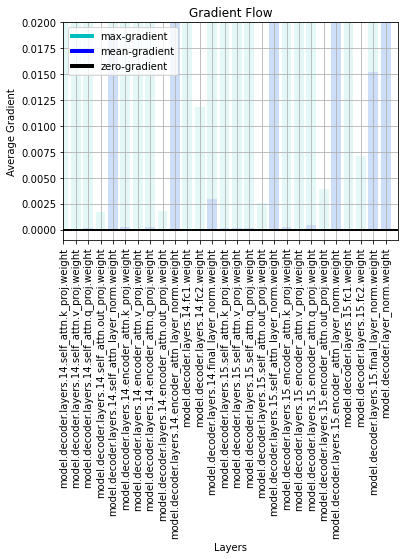

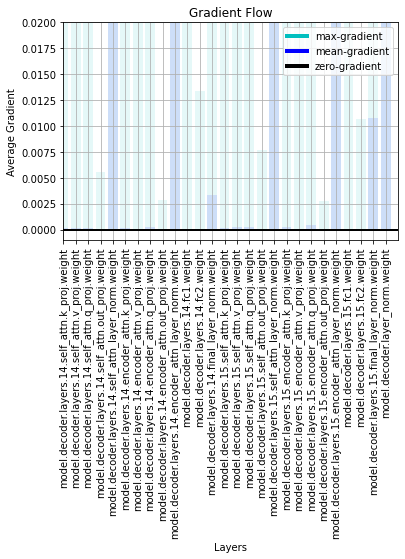

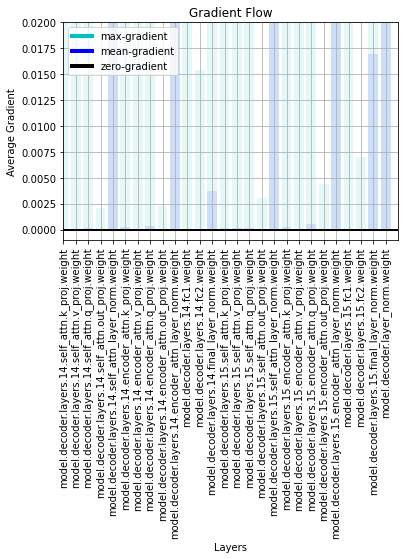

In [56]:
logger.info(show_gpu(f' GPU memory usage after loading models:'))
progress_bar = tqdm(range(n_train_steps))
for epoch in range(n_train_epochs): 
    logger.info(f"Now on epoch {epoch} of {n_train_epochs}")
    if not pp_model.training: pp_model.train()
    for i, data in enumerate(dl_train): 
        if i % 10 == 0 :   logging.info(f"Now processing batch {i} out of {len(dl_train)}")
        training_step(data) 
            
        # For debugging
        # print_info_on_generated_text()
        progress_bar.update(1)   
    if wandb_log_grads and epoch % wandb_log_grads_freq == 0: 
        plt = plot_grad_flow(pp_model.named_parameters())
        wandb.log({"gradient flow": wandb.Image(plt)})  # doesn't work as a non-image (i.e. plotly)
        del plt 
    gc.collect() 
    torch.cuda.empty_cache()
    # Evaluation loop
    if epoch % eval_freq == 0: 
        train_set_preds = eval_dl(dl = dl_train)
        valid_set_preds = eval_dl(dl = dl_valid)
        # can't update the tables every epoch, so store them and do it at the end 
        update_training_summary_table(train_set_preds, split='train')
        update_training_summary_table(valid_set_preds, split='valid')
        update_wandb_table(train_set_preds, split='train')
        update_wandb_table(valid_set_preds, split='valid')
        #del train_set_preds
        #del valid_set_preds
            
# Eval on test set 
test_set_preds = eval_dl(dl = dl_test)
update_wandb_table(test_set_preds, split='test')
# Log, plot, and finish up
log_wandb_tables()
plot_wandb_charts()
add_wandb_run_summary_statistics()
wandb.finish()

## Testing and debugging 

### Verifying that the weights update each training step 

In [ ]:
#check_parameters_update(dl)  # from utils script

## Code scraps 

### Experiments around plotting average parameter updates 

In [ ]:
# def get_parameter_group_dict(): 
#     """Function to create "groups" of parameters. This is useful to check how much a group of 
#     parameters updates at an epoch. 
#     Parameter groups are hardcoded into this code for now. 
#     """
#     # Identify which parameters should be grouped together
#     isolates = ['model.shared.weight',"model.encoder.embed_positions.weight", "model.encoder.layer_norm",
#                 "model.decoder.embed_positions.weight", "model.decoder.layer_norm"]
#     layers_base = ["model.encoder.layers", "model.decoder.layers"]
#     def flatten_list(l): return list(np.concatenate(l).flat)
#     layers = flatten_list([[lyr + "." + str(o) +"." for o in list(range(16))] for lyr in layers_base])
#     parameter_groups = layers + isolates
#     # Sort the parameter groups by the order they appear in the model 
#     all_params = [name for name,_ in pp_model.named_parameters()]
#     ordering = [np.min(np.where([pg in o for o in all_params])) for pg in parameter_groups]
#     parameter_groups = [o for _,o in sorted(zip(ordering, parameter_groups))]
#     # Assign each model parameter a parameter group 
#     group_d = dict()
#     for pg in parameter_groups: 
#         name = pg[:-1] if pg in layers else pg  # remove the "." from the end of the name for the numeric layers
#         group_d[name] = [o for o in all_params if pg in o]
#     return group_d

In [ ]:
# def get_parameter_update_amount(): 
#     group_d = get_parameter_group_dict()
#     params_all_initial_d = dict(params_all_initial)
#     params_all_d = dict(params_all)
#     group_d = get_parameter_group_dict()
#     df_d = dict()
#     for k,param_l in group_d.items(): 
#         l = list()
#         for p in param_l: 
#             l.append((params_all_initial_d[p] - params_all_d[p]).abs().flatten())
#         l = torch.cat(l).cpu().detach().numpy()  # list of 1-d tensors to tensor and then to numpy
#         df_d[k] = pd.DataFrame(l).describe().values.flatten()
#     df = pd.DataFrame(df_d)
#     df.index = pd.DataFrame([1,2,3]).describe().index
#     return df 

In [ ]:
## Random code snippets

# initial_params = [(name, p.detach().clone()) for (name, p) in pp_model.named_parameters()]
# loss, reward, pp_logp = training_step(data) 
# update_d =  dict()
# for (_,old_p), (name, new_p) in zip(initial_params, pp_model.named_parameters()): 
#     update_d[name] = torch.abs(old_p - new_p).detach().flatten()     
    
#             update_d =  dict()
#             for (_,old_p), (name, new_p) in zip(initial_params, pp_model.named_parameters()): 
#                 update_d[name] = torch.abs(old_p - new_p).flatten() 
#                 print (name, torch.norm(new_p - old_p).item())  
            
#             group_d = get_parameter_group_dict()
#             initial_params_d,current_params_d = dict(initial_params),dict()
#             params_all_d = dict(params_all)
#             group_d = get_parameter_group_dict()
#             df_d = dict()
#             for k,param_l in group_d.items(): 
#                 l = list()
#                 for p in param_l: 
#                     l.append((params_all_initial_d[p] - params_all_d[p]).abs().flatten())
#                 l = torch.cat(l).cpu().detach().numpy()  # list of 1-d tensors to tensor and then to numpy
#                 df_d[k] = pd.DataFrame(l).describe().values.flatten()
#             df = pd.DataFrame(df_d)
#             df.index = pd.DataFrame([1,2,3]).describe().index

### Generating a paraphrase dataset and getting VM predictions for it

In [ ]:
# def create_paraphrase_dataset(batch, cname_input, cname_output, num_beams=32,
#                               num_return_sequences=32): 
#     """Create paraphrases for each example in the batch. Then repeat the other fields 
#         so that the resulting datase has the same length as the number of paraphrases. 
#         Key assumption is 
#         that the same number of paraphrases is created for each example.
#         batch: a dict of examples used by the `map` function from the dataset
#         cname_input: What column to create paraphrases of 
#         cname_output: What to call the column of paraphrases
#         other parameters - passed to get_paraphrases. """
    
#     # Generate paraphrases. 
#     # This can be later extended to add diversity or so on. 
#     #set_trace()
#     pp_l,probs = get_paraphrases(batch[cname_input], num_beams=num_beams,
#         num_return_sequences=num_return_sequences)
    
#     # To return paraphrases as a list of lists for batch input (not done here but might need later)
#     #     split_into_sublists = lambda l,n: [l[i:i + n] for i in range(0, len(l), n)]
#     #     pp_l = split_into_sublists(pp_l, n_seed_seqs)
#     batch[cname_output] = pp_l 
#     batch["probs"] = probs.to('cpu').numpy()
    
#     # Repeat each entry in all other columns `num_return_sequences` times so they are the same length
#     # as the paraphrase column
#     # Only works if the same number of paraphrases is generated for each phrase. 
#     # Else try something like 
#         # for o in zip(*batch.values()):
#         #     d = dict(zip(batch.keys(), o))
#         #     get_paraphrases(batch[cname_input],num_return_sequences=n_seed_seqs,num_beams=n_seed_seqs)
#         #     for k,v in d.items(): 
#         #       return_d[k] += v if k == 'text' else [v for o in range(n_paraphrases)]
#         # return return_d
#     return_d = defaultdict(list) 
#     repeat_each_item_n_times = lambda l,n: [o for o in l for i in range(n)]
#     for k in batch.keys(): 
#         if   k == cname_output: return_d[k] = batch[cname_output]
#         elif k == "probs"     : return_d[k] = batch["probs"]
#         else:                   return_d[k] = repeat_each_item_n_times(batch[k], num_return_sequences)
#     return return_d 

In [ ]:
# def get_vm_scores(ds_pp, cname_orig, cname_pp, cname_label='label', 
#                   use_metric=False, monitor=False): 
#     """Get victim model preds+probs for the paraphrase dataset.
#     """
#     assert vm_model.training == False  # checks that model is in eval mode 
#     if use_metric: 
#         metric_d = {}
#         metric_d['orig'],metric_d['pp'] = load_metric('accuracy'),load_metric('accuracy')
#     orig_probs_l,pp_probs_l = [],[]
#     if monitor: monitor = Monitor(2)  # track GPU usage and memory
    
#     def get_vm_preds(x): 
#         """Get predictions for a vector x (here a vector of documents/text). 
#         Works for a sentiment-analysis dataset (needs to be adjusted for NLI tasks)"""
#         inputs = vm_tokenizer(x, padding=True, truncation=True, return_tensors="pt")
#         inputs.to(device)
#         outputs = vm_model(**inputs, labels=labels)
#         probs = outputs.logits.softmax(1).cpu()
#         preds = probs.argmax(1)
#         return probs, preds
       
#     print("Getting victim model predictions for both original and paraphrased text.")
#     dl = DataLoader(ds_pp, batch_size=batch_size, shuffle=False, 
#                     num_workers=n_wkrs, pin_memory=True)
#     with torch.no_grad():
#         for i, data in enumerate(dl): 
#             if i % 50 == 0 : print("Now processing batch", i, "out of", len(dl))
#             labels,orig,pp = data['label'].to(device),data[cname_orig],data[cname_pp]
#             orig_probs, orig_preds = get_vm_preds(orig)            
#             pp_probs,   pp_preds   = get_vm_preds(pp)    
#             orig_probs_l.append(orig_probs); pp_probs_l.append(pp_probs)
#             if use_metric: 
#                 metric_d['orig'].add_batch(predictions=orig_preds, references=labels)
#                 metric_d['pp'].add_batch(  predictions=pp_preds,   references=labels)
#     if monitor: monitor.stop()
#     def list2tensor(l): return torch.cat(l)
#     orig_probs_t,pp_probs_t = list2tensor(orig_probs_l),list2tensor(pp_probs_l)
#     if use_metric: return orig_probs_t, pp_probs_t, metric_d
#     else:          return orig_probs_t, pp_probs_t, None

In [ ]:
# ### Generate paraphrase dataset
# num_beams = 10
# num_return_sequences = 3
# cname_input = 'text' # which text column to paraphrase
# cname_output= cname_input + '_pp'
# date = '20210825'
# fname = path_cache + '_rt_train'+ date + '_' + str(num_return_sequences)
# if os.path.exists(fname):  
#     ds_pp = datasets.load_from_disk(fname)
# else:
#     ds_pp = train.shard(200, 0, contiguous=True)
#     # Have to call with batched=True
#     # Need to set a batch size otherwise will run out of memory on the GPU card. 
#     # 64 seems to work well 
#     ds_pp = ds_pp.map(
#         lambda x: create_paraphrase_dataset(x, 
#             num_beams=num_beams, num_return_sequences=num_return_sequences,
#             cname_input=cname_input, cname_output=cname_output),
#         batched=True, batch_size=4) 
#     ds_pp.save_to_disk(fname)
#     gc.collect(); torch.cuda.empty_cache() # free up most of the GPU memory

In [ ]:
# ### Get predictions
# cname_orig = cname_input
# cname_pp = cname_output
# cname_label = 'label'
# print_metric = True
# fname = path_cache + 'results_df_'+ date + "_" + str(num_return_sequences) + ".csv"
# if os.path.exists(fname):    results_df = pd.read_csv(fname)
# else: 
#     #sim_score_t = generate_sim_scores()
#     orig_probs_t,pp_probs_t,metric_d = get_vm_scores(ds_pp, cname_orig, 
#                                                      cname_pp, cname_label,
#                                                      monitor=True, use_metric=print_metric)
#     if print_metric: 
#         print("orig vm accuracy:",       metric_d['orig'].compute())
#         print("paraphrase vm accuracy:", metric_d['pp'].compute())
#     vm_orig_scores  = torch.tensor([r[idx] for idx,r in zip(ds_pp[cname_label], orig_probs_t)])
#     vm_pp_scores    = torch.tensor([r[idx] for idx,r in zip(ds_pp[cname_label], pp_probs_t)])
#     results_df = pd.DataFrame({
#                   cname_orig: ds_pp[cname_orig],
#                   cname_pp: ds_pp[cname_pp],
#    #               'sim_score': sim_score_t,
#                   'label_true': ds_pp[cname_label], 
#                   'label_vm_orig': orig_probs_t.argmax(1),
#                   'label_vm_pp': pp_probs_t.argmax(1),
#                   'vm_orig_truelabel': vm_orig_scores,             
#                   'vm_pp_truelabel': vm_pp_scores,
#                   'vm_truelabel_change': vm_orig_scores - vm_pp_scores,
#                   'vm_orig_class0': orig_probs_t[:,0], 
#                   'vm_orig_class1': orig_probs_t[:,1], 
#                   'vm_pp_class0': pp_probs_t[:,0], 
#                   'vm_pp_class1': pp_probs_t[:,1], 
#                   })
# #    results_df['vm_truelabel_change_X_sim_score'] = results_df['vm_truelabel_change'] * results_df['sim_score']
#     results_df.to_csv(fname, index_label = 'idx')

### Testing how to keep gradients with `generate` functions

In [ ]:
# ### Testing the `generate_with_grad` function

# input_text="hello my name is Tom"
# num_return_sequences=1
# num_beams=2
# return_probs=True
# batch = pp_tokenizer(input_text, truncation=True, padding='longest', return_tensors="pt").to(device)
# generated = pp_model.generate_with_grad(**batch, return_dict_in_generate=True, output_scores=True,
#                               num_return_sequences=num_return_sequences,
#                                 num_beams=num_beams,
#                                 num_beam_groups=1,
#                                 diversity_penalty=0,
#                                 temperature=1.5, 
#                               length_penalty=1)
# print(generated)

# tgt_text = pp_tokenizer.batch_decode(generated.sequences, skip_special_tokens=True)
# print(pp_tokenizer.tokenize(tgt_text[0]))
# print(pp_tokenizer.encode(tgt_text[0]))

# # Score: score = sum_logprobs / (hyp.shape[-1] ** self.length_penalty)
# # gradient gets removed (i think) by the line 
# # beam_hyp.add(
# #   input_ids[batch_beam_idx].clone(),
# #   next_score.item())


# x=generated['scores'][5]
# print(x.max(1))
# x.max(1).values / (len(generated['scores']) ** 0.8)

In [ ]:
## An example of how to use greedy_search

# from transformers import (
# AutoTokenizer,
# AutoModelForCausalLM,
# LogitsProcessorList,
# MinLengthLogitsProcessor,
# )

# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = AutoModelForCausalLM.from_pretrained("gpt2")

# # set pad_token_id to eos_token_id because GPT2 does not have a EOS token
# model.config.pad_token_id = model.config.eos_token_id

# input_prompt = "Today is a beautiful day, and"
# input_ids = tokenizer(input_prompt, return_tensors="pt").input_ids

# # instantiate logits processors
# logits_processor = LogitsProcessorList([
#     MinLengthLogitsProcessor(15, eos_token_id=model.config.eos_token_id),
# ])

# outputs = model.greedy_search(input_ids, logits_processor=logits_processor)

# print("Generated:", tokenizer.batch_decode(outputs, skip_special_tokens=True))

### Tensorboard setup 

In [ ]:

# from torch.utils.tensorboard import SummaryWriter
# import datetime 
# # Create writer and track to run directory 
# path_runs = './runs/'
# log_dir = path_runs + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
# writer = SummaryWriter(log_dir = log_dir)
# # stuff here logging to tensorboard
# #writer.close() # important otherwise Tensorboard eventually shuts down


### WandB artifact tables 

In [ ]:
# log predictions table to wandb, giving it a name
#  train_table_artifact = wandb.Artifact("train_samples_" + str(wandb.run.id), type="predictions")
#  valid_table_artifact = wandb.Artifact("test_samples_"   + str(wandb.run.id), type="predictions")
#train_table_artifact.add(train_table, "predictions")
#valid_table_artifact.add(valid_table, "predictions")
#wandb.run.log_artifact(train_table_artifact) 
#wandb.run.log_artifact(valid_table_artifact)

### A no_grad version of `model.generate()` adapted from transformers v4.5.0

In [ ]:
# from typing import Any, Callable, Dict, Iterable, List, Mapping, Optional, Union
# from transformers.generation_beam_search import BeamScorer, BeamSearchScorer
# import torch


# def generate_with_grad(
#     self,
#     input_ids: Optional[torch.LongTensor] = None,
#     max_length: Optional[int] = None,
#     min_length: Optional[int] = None,
#     do_sample: Optional[bool] = None,
#     early_stopping: Optional[bool] = None,
#     num_beams: Optional[int] = None,
#     temperature: Optional[float] = None,
#     top_k: Optional[int] = None,
#     top_p: Optional[float] = None,
#     repetition_penalty: Optional[float] = None,
#     bad_words_ids: Optional[Iterable[int]] = None,
#     bos_token_id: Optional[int] = None,
#     pad_token_id: Optional[int] = None,
#     eos_token_id: Optional[int] = None,
#     length_penalty: Optional[float] = None,
#     no_repeat_ngram_size: Optional[int] = None,
#     encoder_no_repeat_ngram_size: Optional[int] = None,
#     num_return_sequences: Optional[int] = None,
#     max_time: Optional[float] = None,
#     decoder_start_token_id: Optional[int] = None,
#     use_cache: Optional[bool] = None,
#     num_beam_groups: Optional[int] = None,
#     diversity_penalty: Optional[float] = None,
#     prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
#     output_attentions: Optional[bool] = None,
#     output_hidden_states: Optional[bool] = None,
#     output_scores: Optional[bool] = None,
#     return_dict_in_generate: Optional[bool] = None,
#     forced_bos_token_id: Optional[int] = None,
#     forced_eos_token_id: Optional[int] = None,
#     remove_invalid_values: Optional[bool] = None,
#     **model_kwargs):
#     # set init values
#     num_beams = num_beams if num_beams is not None else self.config.num_beams
#     num_beam_groups = num_beam_groups if num_beam_groups is not None else self.config.num_beam_groups
#     max_length = max_length if max_length is not None else self.config.max_length
#     do_sample = do_sample if do_sample is not None else self.config.do_sample
#     num_return_sequences = (
#         num_return_sequences if num_return_sequences is not None else self.config.num_return_sequences
#     )

#     pad_token_id = pad_token_id if pad_token_id is not None else self.config.pad_token_id
#     bos_token_id = bos_token_id if bos_token_id is not None else self.config.bos_token_id
#     eos_token_id = eos_token_id if eos_token_id is not None else self.config.eos_token_id

#     output_scores = output_scores if output_scores is not None else self.config.output_scores
#     output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
#     output_hidden_states = (
#         output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
#     )
#     return_dict_in_generate = (
#         return_dict_in_generate if return_dict_in_generate is not None else self.config.return_dict_in_generate
#     )

#     model_kwargs["output_attentions"] = output_attentions
#     model_kwargs["output_hidden_states"] = output_hidden_states

#     if input_ids is None:
#         # init `input_ids` with bos_token_id
#         input_ids = self._prepare_input_ids_for_generation(bos_token_id, model_kwargs.get("encoder_outputs"))

#     if model_kwargs.get("attention_mask", None) is None:
#         # init `attention_mask` depending on `pad_token_id`
#         model_kwargs["attention_mask"] = self._prepare_attention_mask_for_generation(
#             input_ids, pad_token_id, eos_token_id
#         )

#     # special case if pad_token_id is not defined
#     if pad_token_id is None and eos_token_id is not None:
#         logger.warning(f"Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation.")
#         pad_token_id = eos_token_id

#     # Storing encoder_input_ids for logits_processor that could use them
#     encoder_input_ids = input_ids if self.config.is_encoder_decoder else None

#     if self.config.is_encoder_decoder:
#         # add encoder_outputs to model_kwargs
#         model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(input_ids, model_kwargs)

#         # set input_ids as decoder_input_ids
#         if "decoder_input_ids" in model_kwargs:
#             input_ids = model_kwargs.pop("decoder_input_ids")
#         else:
#             input_ids = self._prepare_decoder_input_ids_for_generation(
#                 input_ids, decoder_start_token_id=decoder_start_token_id, bos_token_id=bos_token_id
#             )

# #         if "encoder_outputs" not in model_kwargs or not isinstance(model_kwargs["encoder_outputs"], ModelOutput):
# #             raise ValueError("Make sure that `model_kwargs` include `encoder_outputs` of type `ModelOutput`.")
#     if input_ids.shape[-1] >= max_length:
#         input_ids_string = "decoder_input_ids" if self.config.is_encoder_decoder else "input_ids"
#         logger.warning(
#             f"Input length of {input_ids_string} is {input_ids.shape[-1]}, but ``max_length`` is set to {max_length}."
#             "This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``."
#         )

#     # determine generation mode
#     is_greedy_gen_mode = (num_beams == 1) and (num_beam_groups == 1) and do_sample is False
#     is_sample_gen_mode = (num_beams == 1) and (num_beam_groups == 1) and do_sample is True
#     is_beam_gen_mode = (num_beams > 1) and (num_beam_groups == 1) and do_sample is False
#     is_beam_sample_gen_mode = (num_beams > 1) and (num_beam_groups == 1) and do_sample is True
#     is_group_beam_gen_mode = (num_beams > 1) and (num_beam_groups > 1)
#     if num_beam_groups > num_beams:
#         raise ValueError("`num_beam_groups` has to be smaller or equal to `num_beams`")
#     if is_group_beam_gen_mode and do_sample is True:
#         raise ValueError(
#             "Diverse beam search cannot be used in sampling mode. Make sure that `do_sample` is set to `False`."
#         )

#     # set model_kwargs
#     model_kwargs["use_cache"] = use_cache

#     # get distribution pre_processing samplers
#     logits_processor = self._get_logits_processor(
#         repetition_penalty=repetition_penalty,
#         no_repeat_ngram_size=no_repeat_ngram_size,
#         encoder_no_repeat_ngram_size=encoder_no_repeat_ngram_size,
#         encoder_input_ids=encoder_input_ids,
#         bad_words_ids=bad_words_ids,
#         min_length=min_length,
#         max_length=max_length,
#         eos_token_id=eos_token_id,
#         forced_bos_token_id=forced_bos_token_id,
#         forced_eos_token_id=forced_eos_token_id,
#         prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
#         num_beams=num_beams,
#         num_beam_groups=num_beam_groups,
#         diversity_penalty=diversity_penalty,
#         remove_invalid_values=remove_invalid_values,
#     )

#     stopping_criteria = self._get_stopping_criteria(
#         max_length=max_length,
#         max_time=max_time,
#     )

#     if is_greedy_gen_mode:
#         if num_return_sequences > 1:
#             raise ValueError(
#                 f"num_return_sequences has to be 1, but is {num_return_sequences} when doing greedy search."
#             )

#         # greedy search
#         return self.greedy_search(
#             input_ids,
#             logits_processor=logits_processor,
#             stopping_criteria=stopping_criteria,
#             max_length=max_length,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#             output_scores=output_scores,
#             return_dict_in_generate=return_dict_in_generate,
#             **model_kwargs,
#         )

#     elif is_sample_gen_mode:
#         # get probability distribution warper
#         logits_warper = self._get_logits_warper(
#             top_k=top_k, top_p=top_p, temperature=temperature, num_beams=num_beams
#         )

#         # expand input_ids with `num_return_sequences` additional sequences per batch
#         input_ids, model_kwargs = self._expand_inputs_for_generation(
#             input_ids,
#             expand_size=num_return_sequences,
#             is_encoder_decoder=self.config.is_encoder_decoder,
#             **model_kwargs,
#         )

#         # sample
#         return self.sample(
#             input_ids,
#             logits_processor=logits_processor,
#             logits_warper=logits_warper,
#             stopping_criteria=stopping_criteria,
#             max_length=max_length,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#             output_scores=output_scores,
#             return_dict_in_generate=return_dict_in_generate,
#             **model_kwargs,
#         )

#     elif is_beam_gen_mode:
#         batch_size = input_ids.shape[0]

#         length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
#         early_stopping = early_stopping if early_stopping is not None else self.config.early_stopping

#         if num_return_sequences > num_beams:
#             raise ValueError("`num_return_sequences` has to be smaller or equal to `num_beams`.")

#         beam_scorer = BeamSearchScorer(
#             batch_size=batch_size,
#             max_length=max_length,
#             num_beams=num_beams,
#             device=self.device,
#             length_penalty=length_penalty,
#             do_early_stopping=early_stopping,
#             num_beam_hyps_to_keep=num_return_sequences,
#         )
#         # interleave with `num_beams`
#         input_ids, model_kwargs = self._expand_inputs_for_generation(
#             input_ids, expand_size=num_beams, is_encoder_decoder=self.config.is_encoder_decoder, **model_kwargs
#         )
#         #with torchsnooper.snoop(depth=4, max_variable_length=200, normalize=True):
#         return self.beam_search(
#             input_ids,
#             beam_scorer,
#             logits_processor=logits_processor,
#             stopping_criteria=stopping_criteria,
#             max_length=max_length,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#             output_scores=output_scores,
#             return_dict_in_generate=return_dict_in_generate,
#             **model_kwargs,
#         )

#     elif is_beam_sample_gen_mode:
#         logits_warper = self._get_logits_warper(
#             top_k=top_k, top_p=top_p, temperature=temperature, num_beams=num_beams
#         )

#         batch_size = input_ids.shape[0] * num_return_sequences

#         length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
#         beam_scorer = BeamSearchScorer(
#             batch_size=batch_size,
#             max_length=max_length,
#             num_beams=num_beams,
#             device=self.device,
#             length_penalty=length_penalty,
#             do_early_stopping=early_stopping,
#         )

#         # interleave with `num_beams * num_return_sequences`
#         input_ids, model_kwargs = self._expand_inputs_for_generation(
#             input_ids,
#             expand_size=num_beams * num_return_sequences,
#             is_encoder_decoder=self.config.is_encoder_decoder,
#             **model_kwargs,
#         )

#         return self.beam_sample(
#             input_ids,
#             beam_scorer,
#             logits_processor=logits_processor,
#             logits_warper=logits_warper,
#             stopping_criteria=stopping_criteria,
#             max_length=max_length,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#             output_scores=output_scores,
#             return_dict_in_generate=return_dict_in_generate,
#             **model_kwargs,
#         )

#     elif is_group_beam_gen_mode:
#         batch_size = input_ids.shape[0]

#         length_penalty = length_penalty if length_penalty is not None else self.config.length_penalty
#         early_stopping = early_stopping if early_stopping is not None else self.config.early_stopping

#         if num_return_sequences > num_beams:
#             raise ValueError("`num_return_sequences` has to be smaller or equal to `num_beams`.")

#         if num_beams % num_beam_groups != 0:
#             raise ValueError("`num_beams` should be divisible by `num_beam_groups` for group beam search.")

#         diverse_beam_scorer = BeamSearchScorer(
#             batch_size=batch_size,
#             max_length=max_length,
#             num_beams=num_beams,
#             device=self.device,
#             length_penalty=length_penalty,
#             do_early_stopping=early_stopping,
#             num_beam_hyps_to_keep=num_return_sequences,
#             num_beam_groups=num_beam_groups,
#         )
#         # interleave with `num_beams`
#         input_ids, model_kwargs = self._expand_inputs_for_generation(
#             input_ids, expand_size=num_beams, is_encoder_decoder=self.config.is_encoder_decoder, **model_kwargs
#         )
#         return self.group_beam_search(
#             input_ids,
#             diverse_beam_scorer,
#             logits_processor=logits_processor,
#             stopping_criteria=stopping_criteria,
#             max_length=max_length,
#             pad_token_id=pad_token_id,
#             eos_token_id=eos_token_id,
#             output_scores=output_scores,
#             return_dict_in_generate=return_dict_in_generate,
#             **model_kwargs,
#         )


### Old eval/wandb functions 

In [ ]:
# def print_eval_metrics(preds, split):
#     ### Might be obselete ###
#     print(f"{split} paraphrases:", preds['pp_l'])
#     print(f"{split} VM scores:",    np.round(preds['vm_score'],3))
#     print(f"{split} ROUGE scores:", np.round(preds['rouge_score'],3))
#     if normalise_rewards: print(f"{split} unnormalised rewards:", preds['orig_reward'])
#     print(f"{split} rewards:", round_t(preds['reward'], 3))
#     print(f"{split} avg reward:", torch.mean(preds['reward']).item())
#     print(f"{split} logp:", round_t(preds['pp_logp'], 3))
#     print(f"{split} avg logp:", torch.mean(preds['pp_logp']).item())
#     print(f"{split} loss:", train_set_preds['loss'].item())

In [ ]:
# def log_wandb_metrics(results_d, split): 
#     """flattens lists of metrics to wandb acceptable form. obselete now but might be useful later"""
#     #### MIGHT BE OBSELETE #####
#     # Log numeric data 
#     # Convert all lists of values to wandb format. Scalars are unchanged
#     d = dict()
#     orig_keys = results_d.keys()
#     for k,v in results_d.items(): 
#         if type(v) is list: 
#             if type(v[0]) == int or type(v[0]) == float:  # we handle strings differently
#                 d1 = {f"eval/{split}/examples/{k}/{i}": o for i,o in enumerate(v)}  # list -> dict of len(v) scalars
#                 d = {**d, **d1}  # merge dicts
#         else: 
#             d[f"{split}/{k}"] = v
#     d['epoch'] = epoch
#     wandb.log(d) 

In [ ]:
### An attempt to rename wandb columns of a table. This seemed to break something internally inside the table.
#
#     def rename_wandb_column(table, old, new): 
#         if old not in table.columns: 
#             warnings.warn(f"{old} not in columns of table. Skipping. Columns of table are {table.columns}")
#         else: 
#             idx = [i for i,o in enumerate(table.columns) if o == old][0]
#             table.columns[idx] = new
        
    # Can't just originally name these 'orig' and 'pp' because they don't match key names used in `eval_dl`
    # NOTE: this seems to break the internals of wandb. might have to just live with the names. 
#     rename_wandb_column(train_table, old='orig_l', new='orig')
#     rename_wandb_column(train_table, old='pp_l',   new='pp')
#     rename_wandb_column(valid_table,  old='orig_l', new='orig')
#     rename_wandb_column(valid_table,  old='pp_l',   new='pp')